<a href="https://colab.research.google.com/github/kchabin/pp_tech/blob/main/Midterm_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import pairwise_distances

In [4]:
# 데이터 로드
d1 = pd.read_csv("/content/data 1_midterm.csv")
print(d1)

      age  income  family_num  credit_loan
0      25      49           4            0
1      45      34           3            0
2      39      11           1            0
3      35     100           1            0
4      35      45           4            0
...   ...     ...         ...          ...
2495   46      70           4            0
2496   63      32           3            0
2497   33      14           3            0
2498   38     111           2            0
2499   53      38           4            0

[2500 rows x 4 columns]


데이터
- 모델 개발 시 , 기본 분석에는 data 1 사용
- 나이 , 소득 , 가족 수는 준식별자 , 신용 대출 여부는 민감정보로
사용하고 나머지는 삭제

상하단 코딩 or 범주화
- 둘 중 하나만 선택해서 하면 되는건지 여쭤보기
- 상하단 코딩 후 범주화

### data 1 데이터 그래프로 확인하기

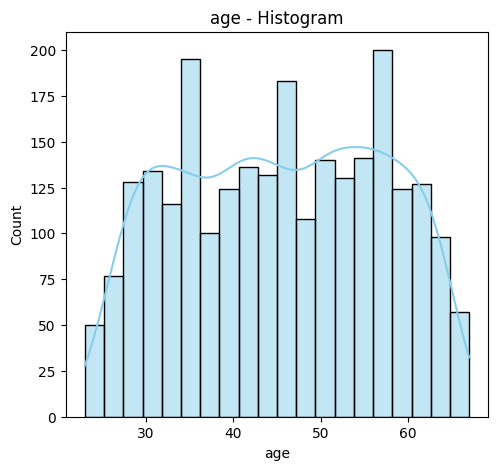

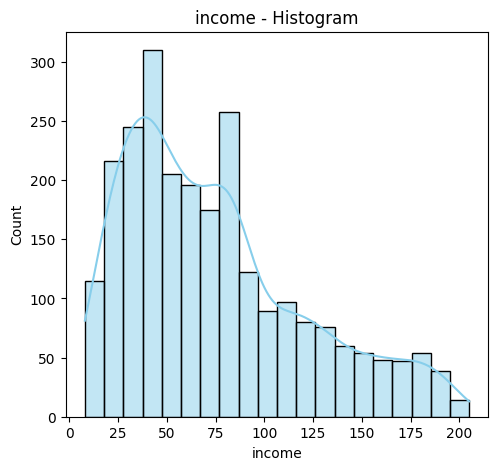

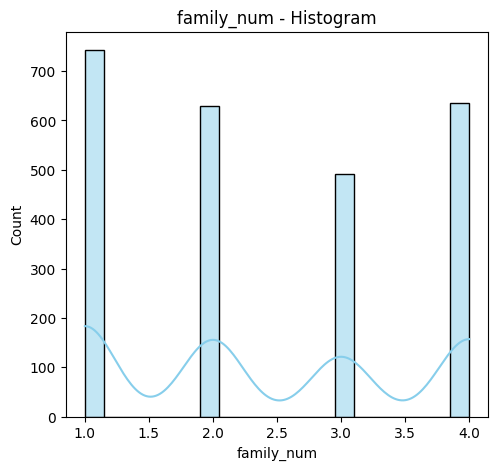

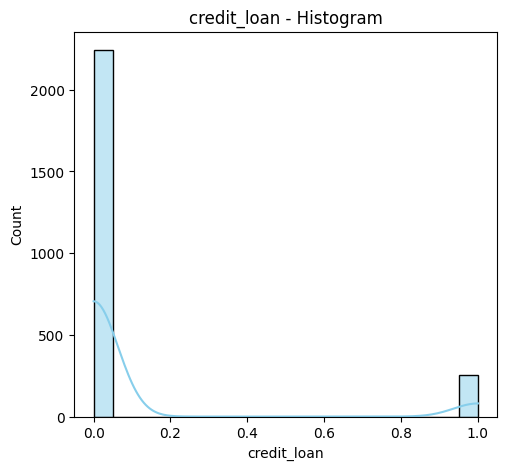

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns



# 히스토그램 & 박스플롯을 그릴 컬럼 리스트 지정
columns = ['age', 'income', 'family_num', 'credit_loan']  # 예시: 나이, 소득, 가족수

# 시각화 시작
for col in columns:
    plt.figure(figsize=(12,5))

    # 히스토그램
    plt.subplot(1, 2, 1)
    sns.histplot(d1[col], kde=True, bins=20, color='skyblue')
    plt.title(f'{col} - Histogram')


    plt.show()


## 정규분포 기반 상하단 코딩

In [92]:
def apply_coding_normal(df, column, sigma_range):
    # 복사본을 사용하여 원본 데이터 수정하지 않도록 방지
    df_copy = df.copy()
    mean = df_copy[column].mean()
    std = df_copy[column].std()

    lower_bound = mean - sigma_range * std
    upper_bound = mean + sigma_range * std

    print(f"정규분포 경계값 (±{sigma_range}σ) for {column}: {lower_bound:.1f} ~ {upper_bound:.1f}")

    df_copy[column] = df_copy[column].clip(lower=lower_bound, upper=upper_bound).round().astype(int)
    return df_copy


In [93]:
df_norm = apply_coding_normal(d1, column='income', sigma_range=3)
df_norm = apply_coding_normal(df_norm, column='age', sigma_range=3)
df_norm.tail(100)

정규분포 경계값 (±3σ) for income: -65.6 ~ 214.5
정규분포 경계값 (±3σ) for age: 10.8 ~ 79.9


,age,income,family_num,credit_loan
2400,61,169,2,1
2401,42,63,2,0
2402,48,23,3,0
2403,38,140,4,1
2404,41,75,1,0
...,...,...,...,...
2495,46,70,4,0
2496,63,32,3,0
2497,33,14,3,0
2498,38,111,2,0


In [100]:
d1_sig2 = apply_coding_normal(d1, column='income', sigma_range=2)
d1_sig2 = apply_coding_normal(d1_sig2, column='age', sigma_range=2)
d1_sig2.tail(100)

,age,income,family_num,credit_loan
2400,61,168,2,1
2401,42,63,2,0
2402,48,23,3,0
2403,38,140,4,1
2404,41,75,1,0
...,...,...,...,...
2495,46,70,4,0
2496,63,32,3,0
2497,33,14,3,0
2498,38,111,2,0


`family_num`에도 상하단 코딩을 적용해야 하나요... -> no

sigma값을 1~3 중 적용한 결과를 보여주고 그 중에서 최적 값 선택

** 핵심 요점**

apply_coding_normal 함수는 넘겨준 df의 복사본을 반환하는 구조.

두 번 호출할 때 같은 d1 원본을 넘기면 이전 적용 결과가 사라진다.

순차적으로 적용하려면, 첫 번째 결과를 두 번째 함수에 넘겨줘야 함.

In [11]:
d1_norm = d1.copy()
# income 컬럼에 대해 클리핑 적용
d1_norm = apply_coding_normal(d1_norm, column='income', sigma_range=1)

# income에 클리핑 적용 후, age 컬럼에 대해 클리핑 적용
d1_norm = apply_coding_normal(d1_norm, column='age', sigma_range=1)

# 결과 확인
print(d1_norm.tail(100))


정규분포 경계값 (±1σ) for income: 27.8 ~ 121.1
정규분포 경계값 (±1σ) for age: 33.8 ~ 56.9
      age  income  family_num  credit_loan
2400   57     121           2            1
2401   42      63           2            0
2402   48      28           3            0
2403   38     121           4            1
2404   41      75           1            0
...   ...     ...         ...          ...
2495   46      70           4            0
2496   57      32           3            0
2497   34      28           3            0
2498   38     111           2            0
2499   53      38           4            0

[100 rows x 4 columns]


가장 정규분포 경계값이 정상적으로 보이는 건 sigma_range=1 일 때였음

## 범주화

### 나이 10. 소득 20

In [12]:
import pandas as pd

def apply_binning(df, age_bin, income_bin, fam_bin):
    def bin_column(data, col, bin_size):
        min_val = int(data[col].min())
        max_val = int(data[col].max())

        # family_num은 최대값이 너무 작아서 범주 구간이 부족한 경우 처리
        if bin_size >= (max_val - min_val + 1):
            bins = [min_val, max_val + 1]  # 최소-최대 한 구간만 생성
        else:
            bins = list(range(min_val, max_val + bin_size, bin_size))

        labels = [f"{b}~{b+bin_size-1}" for b in bins[:-1]]
        return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

    df = df.copy()
    df['age'] = bin_column(df, 'age', age_bin)
    df['income'] = bin_column(df, 'income', income_bin)
    df['family_num'] = bin_column(df, 'family_num', fam_bin)

    return df

# 사용자 입력
age_bin = int(input("나이 범위(예: 10): "))
income_bin = int(input("소득 범위(예: 20): "))
fam_bin = int(input("가족 수 범위(예: 2): "))

# 적용
d1_norm_binned = apply_binning(d1_norm, age_bin=age_bin, income_bin=income_bin, fam_bin=fam_bin)

# 확인
print(d1_norm_binned.head())


나이 범위(예: 10): 10
소득 범위(예: 20): 20
가족 수 범위(예: 2): 2
     age  income family_num  credit_loan
0  34~43   48~67        3~4            0
1  44~53   28~47        3~4            0
2  34~43   28~47        1~2            0
3  34~43  88~107        1~2            0
4  34~43   28~47        3~4            0


### 나이 10. 소득 30

In [ ]:
import pandas as pd

def apply_binning(df, age_bin, income_bin, fam_bin):
    def bin_column(data, col, bin_size):
        min_val = int(data[col].min())
        max_val = int(data[col].max())

        # family_num은 최대값이 너무 작아서 범주 구간이 부족한 경우 처리
        if bin_size >= (max_val - min_val + 1):
            bins = [min_val, max_val + 1]  # 최소-최대 한 구간만 생성
        else:
            bins = list(range(min_val, max_val + bin_size, bin_size))

        labels = [f"{b}~{b+bin_size-1}" for b in bins[:-1]]
        return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

    df = df.copy()
    df['age'] = bin_column(df, 'age', age_bin)
    df['income'] = bin_column(df, 'income', income_bin)
    df['family_num'] = bin_column(df, 'family_num', fam_bin)

    return df

# 사용자 입력
age_bin = int(input("나이 범위(예: 10): "))
income_bin = int(input("소득 범위(예: 20): "))
fam_bin = int(input("가족 수 범위(예: 2): "))

# 적용
d1_norm_binned2 = apply_binning(d1_norm, age_bin=age_bin, income_bin=income_bin, fam_bin=fam_bin)

# 확인
print(d1_norm_binned2.head())


나이 범위(예: 10): 10
소득 범위(예: 20): 30
가족 수 범위(예: 2): 2
     age  income family_num  credit_loan
0  34~43   28~57        3~4            0
1  44~53   28~57        3~4            0
2  34~43   28~57        1~2            0
3  34~43  88~117        1~2            0
4  34~43   28~57        3~4            0


### 나이 40. 소득 70

In [ ]:
import pandas as pd

def apply_binning(df, age_bin, income_bin, fam_bin):
    def bin_column(data, col, bin_size):
        min_val = int(data[col].min())
        max_val = int(data[col].max())

        # family_num은 최대값이 너무 작아서 범주 구간이 부족한 경우 처리
        if bin_size >= (max_val - min_val + 1):
            bins = [min_val, max_val + 1]  # 최소-최대 한 구간만 생성
        else:
            bins = list(range(min_val, max_val + bin_size, bin_size))

        labels = [f"{b}~{b+bin_size-1}" for b in bins[:-1]]
        return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

    df = df.copy()
    df['age'] = bin_column(df, 'age', age_bin)
    df['income'] = bin_column(df, 'income', income_bin)
    df['family_num'] = bin_column(df, 'family_num', fam_bin)

    return df

# 사용자 입력
age_bin = int(input("나이 범위(예: 10): "))
income_bin = int(input("소득 범위(예: 20): "))
fam_bin = int(input("가족 수 범위(예: 2): "))

# 적용
d1_norm_binned3 = apply_binning(d1_norm, age_bin=age_bin, income_bin=income_bin, fam_bin=fam_bin)

# 확인
print(d1_norm_binned3.head())


나이 범위(예: 10): 40
소득 범위(예: 20): 70
가족 수 범위(예: 2): 2
     age  income family_num  credit_loan
0  34~73   28~97        3~4            0
1  34~73   28~97        3~4            0
2  34~73   28~97        1~2            0
3  34~73  98~167        1~2            0
4  34~73   28~97        3~4            0


### 나이 10. 소득 10

In [ ]:
import pandas as pd

def apply_binning(df, age_bin, income_bin, fam_bin):
    def bin_column(data, col, bin_size):
        min_val = int(data[col].min())
        max_val = int(data[col].max())

        # family_num은 최대값이 너무 작아서 범주 구간이 부족한 경우 처리
        if bin_size >= (max_val - min_val + 1):
            bins = [min_val, max_val + 1]  # 최소-최대 한 구간만 생성
        else:
            bins = list(range(min_val, max_val + bin_size, bin_size))

        labels = [f"{b}~{b+bin_size-1}" for b in bins[:-1]]
        return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

    df = df.copy()
    df['age'] = bin_column(df, 'age', age_bin)
    df['income'] = bin_column(df, 'income', income_bin)
    df['family_num'] = bin_column(df, 'family_num', fam_bin)

    return df

# 사용자 입력
age_bin = int(input("나이 범위(예: 10): "))
income_bin = int(input("소득 범위(예: 20): "))
fam_bin = int(input("가족 수 범위(예: 2): "))

# 적용
d1_norm_binned4 = apply_binning(d1_norm, age_bin=age_bin, income_bin=income_bin, fam_bin=fam_bin)

# 확인
print(d1_norm_binned4.head())


나이 범위(예: 10): 10
소득 범위(예: 20): 10
가족 수 범위(예: 2): 2
     age  income family_num  credit_loan
0  34~43   48~57        3~4            0
1  44~53   28~37        3~4            0
2  34~43   28~37        1~2            0
3  34~43  98~107        1~2            0
4  34~43   38~47        3~4            0


### 나이 15, 소득 20

In [ ]:
import pandas as pd

def apply_binning(df, age_bin, income_bin, fam_bin):
    def bin_column(data, col, bin_size):
        min_val = int(data[col].min())
        max_val = int(data[col].max())

        # family_num은 최대값이 너무 작아서 범주 구간이 부족한 경우 처리
        if bin_size >= (max_val - min_val + 1):
            bins = [min_val, max_val + 1]  # 최소-최대 한 구간만 생성
        else:
            bins = list(range(min_val, max_val + bin_size, bin_size))

        labels = [f"{b}~{b+bin_size-1}" for b in bins[:-1]]
        return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

    df = df.copy()
    df['age'] = bin_column(df, 'age', age_bin)
    df['income'] = bin_column(df, 'income', income_bin)
    df['family_num'] = bin_column(df, 'family_num', fam_bin)

    return df

# 사용자 입력
age_bin = int(input("나이 범위(예: 10): "))
income_bin = int(input("소득 범위(예: 20): "))
fam_bin = int(input("가족 수 범위(예: 2): "))

# 적용
d1_norm_binned5 = apply_binning(d1_norm, age_bin=age_bin, income_bin=income_bin, fam_bin=fam_bin)

# 확인
print(d1_norm_binned5.head())


나이 범위(예: 10): 15
소득 범위(예: 20): 20
가족 수 범위(예: 2): 2
     age  income family_num  credit_loan
0  34~48   48~67        3~4            0
1  34~48   28~47        3~4            0
2  34~48   28~47        1~2            0
3  34~48  88~107        1~2            0
4  34~48   28~47        3~4            0


### 나이 10. 소득 15

In [21]:
import pandas as pd

def apply_binning(df, age_bin, income_bin, fam_bin):
    def bin_column(data, col, bin_size):
        min_val = int(data[col].min())
        max_val = int(data[col].max())

        # family_num은 최대값이 너무 작아서 범주 구간이 부족한 경우 처리
        if bin_size >= (max_val - min_val + 1):
            bins = [min_val, max_val + 1]  # 최소-최대 한 구간만 생성
        else:
            bins = list(range(min_val, max_val + bin_size, bin_size))

        labels = [f"{b}~{b+bin_size-1}" for b in bins[:-1]]
        return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

    df = df.copy()
    df['age'] = bin_column(df, 'age', age_bin)
    df['income'] = bin_column(df, 'income', income_bin)
    df['family_num'] = bin_column(df, 'family_num', fam_bin)

    return df

# 사용자 입력
age_bin = int(input("나이 범위(예: 10): "))
income_bin = int(input("소득 범위(예: 20): "))
fam_bin = int(input("가족 수 범위(예: 2): "))

# 적용
d1_norm_binned6 = apply_binning(d1_norm, age_bin=age_bin, income_bin=income_bin, fam_bin=fam_bin)

# 확인
print(d1_norm_binned6.head())


나이 범위(예: 10): 10
소득 범위(예: 20): 15
가족 수 범위(예: 2): 2
     age  income family_num  credit_loan
0  34~43   43~57        3~4            0
1  44~53   28~42        3~4            0
2  34~43   28~42        1~2            0
3  34~43  88~102        1~2            0
4  34~43   43~57        3~4            0


### 나이 15, 소득 10, 가족 수 3, 시그마 = 2

In [106]:
import pandas as pd

def apply_binning(df, age_bin, income_bin, fam_bin):
    def bin_column(data, col, bin_size):
        min_val = int(data[col].min())
        max_val = int(data[col].max())

        # family_num은 최대값이 너무 작아서 범주 구간이 부족한 경우 처리
        if bin_size >= (max_val - min_val + 1):
          bins = [min_val, max_val + 1]  # 최소-최대 한 구간만 생성
        else:
          bins = list(range(min_val, max_val + bin_size, bin_size))

        labels = [f"{b}~{b+bin_size-1}" for b in bins[:-1]]
        return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

    df = df.copy()
    df['age'] = bin_column(df, 'age', age_bin)
    df['income'] = bin_column(df, 'income', income_bin)
    df['family_num'] = bin_column(df, 'family_num', fam_bin)

    return df

# 사용자 입력
age_bin = int(input("나이 범위(예: 10): "))
income_bin = int(input("소득 범위(예: 20): "))
fam_bin = int(input("가족 수 범위(예: 2): "))

# 적용
d1_norm_binned7 = apply_binning(d1_sig2, age_bin=age_bin, income_bin=income_bin, fam_bin=fam_bin)

# 확인
print(d1_norm_binned7.head())


나이 범위(예: 10): 15
소득 범위(예: 20): 10
가족 수 범위(예: 2): 4
     age  income family_num  credit_loan
0  23~37   48~57        1~4            0
1  38~52   28~37        1~4            0
2  38~52    8~17        1~4            0
3  23~37  98~107        1~4            0
4  23~37   38~47        1~4            0


## K-익명성 - 정규분포 상하단코딩


In [ ]:
# 준식별자와 민감정보 분리
quasi_identifiers = ['age', 'income', 'family_num']
sensitive_attribute = 'credit_loan'

df_qi = d1_norm_binned[quasi_identifiers]  # 준식별자
df_sensitive = d1_norm_binned[sensitive_attribute]  # 민감정보

# 준식별자 기준으로 그룹화하여 'homo_group' 생성
d1_norm_binned['homo_group'] = d1_norm_binned.groupby(quasi_identifiers).ngroup()

# 'd1_binned'에서 'homo_group' 출력
print(d1_norm_binned['homo_group'])


0        3
1       11
2        0
3        6
4        1
        ..
2495    15
2496    21
2497     1
2498     8
2499    11
Name: homo_group, Length: 2500, dtype: int64


<ipython-input-59-fff4984a3f8c>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1_norm_binned['homo_group'] = d1_norm_binned.groupby(quasi_identifiers).ngroup()


In [ ]:
# 준식별자와 민감정보 분리
quasi_identifiers = ['age', 'income', 'family_num']
sensitive_attribute = 'credit_loan'

df_qi = d1_norm_binned2[quasi_identifiers]  # 준식별자
df_sensitive = d1_norm_binned2[sensitive_attribute]  # 민감정보

# 준식별자 기준으로 그룹화하여 'homo_group' 생성
d1_norm_binned2['homo_group'] = d1_norm_binned2.groupby(quasi_identifiers).ngroup()

# 'd1_binned'에서 'homo_group' 출력
print(d1_norm_binned2['homo_group'])


0        1
1        9
2        0
3        4
4        1
        ..
2495    11
2496    17
2497     1
2498     4
2499     9
Name: homo_group, Length: 2500, dtype: int64


<ipython-input-63-b1558a26067b>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1_norm_binned2['homo_group'] = d1_norm_binned2.groupby(quasi_identifiers).ngroup()


In [ ]:
# 준식별자와 민감정보 분리
quasi_identifiers = ['age', 'income', 'family_num']
sensitive_attribute = 'credit_loan'

df_qi = d1_norm_binned3[quasi_identifiers]  # 준식별자
df_sensitive = d1_norm_binned3[sensitive_attribute]  # 민감정보

# 준식별자 기준으로 그룹화하여 'homo_group' 생성
d1_norm_binned3['homo_group'] = d1_norm_binned3.groupby(quasi_identifiers).ngroup()

# 'd1_binned'에서 'homo_group' 출력
print(d1_norm_binned3['homo_group'])


0       1
1       1
2       0
3       2
4       1
       ..
2495    1
2496    1
2497    1
2498    2
2499    1
Name: homo_group, Length: 2500, dtype: int64


<ipython-input-47-d93223cd21d7>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1_norm_binned3['homo_group'] = d1_norm_binned3.groupby(quasi_identifiers).ngroup()


두번째 실습 : 가족 수의 범위를 2로 정했을 때.
- 다른 지표는 동일

In [ ]:
# 준식별자와 민감정보 분리
quasi_identifiers = ['age', 'income', 'family_num']
sensitive_attribute = 'credit_loan'

df_qi = d1_norm_binned4[quasi_identifiers]  # 준식별자
df_sensitive = d1_norm_binned4[sensitive_attribute]  # 민감정보

# 준식별자 기준으로 그룹화하여 'homo_group' 생성
d1_norm_binned4['homo_group'] = d1_norm_binned4.groupby(quasi_identifiers).ngroup()

# 'd2_binned'에서 'homo_group' 출력
print(d1_norm_binned4['homo_group'])


0        5
1       21
2        0
3       14
4        3
        ..
2495    29
2496    41
2497     1
2498    16
2499    23
Name: homo_group, Length: 2500, dtype: int64


<ipython-input-70-6415f50d4b74>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1_norm_binned4['homo_group'] = d1_norm_binned4.groupby(quasi_identifiers).ngroup()


In [ ]:
# 준식별자와 민감정보 분리
quasi_identifiers = ['age', 'income', 'family_num']
sensitive_attribute = 'credit_loan'

df_qi = d1_norm_binned5[quasi_identifiers]  # 준식별자
df_sensitive = d1_norm_binned5[sensitive_attribute]  # 민감정보

# 준식별자 기준으로 그룹화하여 'homo_group' 생성
d1_norm_binned5['homo_group'] = d1_norm_binned5.groupby(quasi_identifiers).ngroup()

# 'd1_norm_binned5'에서 'homo_group' 출력
print(d1_norm_binned5['homo_group'])


0        3
1        1
2        0
3        6
4        1
        ..
2495     5
2496    11
2497     1
2498     8
2499    11
Name: homo_group, Length: 2500, dtype: int64


<ipython-input-18-e82014573dfe>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1_norm_binned5['homo_group'] = d1_norm_binned5.groupby(quasi_identifiers).ngroup()


In [22]:
# 준식별자와 민감정보 분리
quasi_identifiers = ['age', 'income', 'family_num']
sensitive_attribute = 'credit_loan'

df_qi = d1_norm_binned6[quasi_identifiers]  # 준식별자
df_sensitive = d1_norm_binned6[sensitive_attribute]  # 민감정보

# 준식별자 기준으로 그룹화하여 'homo_group' 생성
d1_norm_binned6['homo_group'] = d1_norm_binned6.groupby(quasi_identifiers).ngroup()

# 'd1_norm_binned6'에서 'homo_group' 출력
print(d1_norm_binned6['homo_group'])


0        3
1       15
2        0
3        8
4        3
        ..
2495    19
2496    29
2497     1
2498    10
2499    15
Name: homo_group, Length: 2500, dtype: int64


<ipython-input-22-4bb44f7b04b4>:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d1_norm_binned6['homo_group'] = d1_norm_binned6.groupby(quasi_identifiers).ngroup()


In [107]:
# 준식별자와 민감정보 분리
quasi_identifiers = ['age', 'income', 'family_num']
sensitive_attribute = 'credit_loan'

df_qi = d1_norm_binned7[quasi_identifiers]  # 준식별자
df_sensitive = d1_norm_binned7[sensitive_attribute]  # 민감정보

# 준식별자 기준으로 그룹화하여 'homo_group' 생성
d1_norm_binned7['homo_group'] = d1_norm_binned7.groupby(quasi_identifiers).ngroup()

# 'd1_norm_binned7'에서 'homo_group' 출력
print(d1_norm_binned7['homo_group'])


0        4.0
1       18.0
2       16.0
3        9.0
4        3.0
        ... 
2495    22.0
2496    34.0
2497     0.0
2498    26.0
2499    35.0
Name: homo_group, Length: 2500, dtype: float64


### 나이 범위: 10, 소득 범위: 20, 가족 수: 2 범주화 결과

In [ ]:
group_sizes = d1_norm_binned.groupby('homo_group').size()
min_k = group_sizes.min()
k = group_sizes
print(k)
print(min_k) #15

homo_group
0     187
1     176
2      71
3     115
4      82
5     124
6      61
7      36
8     202
9      75
10    111
11    122
12     35
13     31
14     66
15     66
16     32
17     15
18    118
19     28
20    152
21    138
22     61
23     88
24     45
25     50
26     44
27     23
28    106
29     40
dtype: int64
15


In [ ]:
diversities =d1_norm_binned.groupby('homo_group')[sensitive_attribute].nunique()
print(diversities)

homo_group
0     1
1     1
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9     2
10    1
11    1
12    1
13    1
14    2
15    2
16    2
17    2
18    2
19    2
20    1
21    1
22    1
23    1
24    2
25    1
26    2
27    2
28    2
29    2
Name: credit_loan, dtype: int64


### 나이 범위: 10, 소득 범위: 30, 가족 수: 2 범주화 결과

In [ ]:
group_sizes = d1_norm_binned2.groupby('homo_group').size()
min_k = group_sizes.min()
k = group_sizes
print(k)
print(min_k)

homo_group
0     225
1     240
2     115
3     175
4      95
5      58
6     168
7      53
8     127
9     135
10     85
11     84
12     44
13     17
14    106
15     26
16    180
17    184
18     78
19     92
20     64
21     30
22     86
23     33
dtype: int64
17


### 나이: 40, 소득 범위: 70, 가족 수: 2

In [ ]:
group_sizes = d1_norm_binned3.groupby('homo_group').size()
min_k = group_sizes.min()
k = group_sizes
print(k)
print(min_k)

homo_group
0    893
1    949
2    480
3    178
dtype: int64
178


### 나이 범위: 10, 소득 범위: 10, 가족 수: 2 범주화 결과

In [ ]:
group_sizes = d1_norm_binned4.groupby('homo_group').size()
min_k = group_sizes.min()
k = group_sizes
print(k)
print(min_k)

homo_group
0     118
1     116
2      69
3      60
4      38
5      64
6      33
7      51
8      21
9      64
10     61
11     60
12     30
13     21
14     31
15     15
16     34
17     22
18    168
19     53
20     79
21     77
22     32
23     45
24     16
25     13
26     19
27     18
28     30
29     23
30     36
31     43
32     24
33      9
34      8
35      6
36     12
37      2
38    106
39     26
40    102
41     84
42     50
43     54
44     28
45     46
46     33
47     42
48     20
49     17
50     25
51     33
52     29
53      9
54     15
55     14
56     20
57      7
58     86
59     33
dtype: int64
2


### 나이 15, 소득 20

In [ ]:
group_sizes = d1_norm_binned5.groupby('homo_group').size()
min_k = group_sizes.min()
k = group_sizes
print(k)
print(min_k)

homo_group
0     235
1     218
2      88
3     131
4     112
5     171
6      71
7      46
8     270
9      88
10    215
11    218
12     79
13    103
14     81
15     69
16     66
17     28
18    156
19     55
dtype: int64
28


### 나이 10 소득 15 가족수 2
k=3 만족

In [109]:
group_sizes = d1_norm_binned6.groupby('homo_group').size()
min_k = group_sizes.min()
print(min_k)

3


### 나이 15 소득 10 가족수 4 sigma = 2
 k=9와 k=3 비교:

- k=3: 동일한 준식별자 조합을 가진 레코드가 최소 3개 존재합니다. 따라서 특정 레코드를 1/3 확률로 특정 개인과 연결할 수 있습니다.
- k=9: 동일한 준식별자 조합을 가진 레코드가 최소 9개 존재합니다. 따라서 특정 레코드를 1/9 확률로 특정 개인과 연결할 수 있습니다.

더 높은 k 값의 장점:

- 재식별 위험 감소: k 값이 클수록 특정 개인을 다시 식별해낼 가능성이 낮아져 개인 정보 보호가 강화됩니다.
- 프라이버시 강화: 데이터 분석 시 개인 정보 노출에 대한 우려를 줄일 수 있습니다.




In [108]:
group_sizes = d1_norm_binned7.groupby('homo_group').size()
min_k = group_sizes.min()
k = group_sizes
print(k)
print(min_k)

homo_group
0.0      26
1.0      47
2.0      78
3.0      99
4.0      67
5.0      51
6.0      53
7.0      78
8.0      25
9.0      32
10.0     35
11.0     28
12.0     21
13.0     19
14.0     17
15.0      9
16.0     51
17.0     83
18.0     93
19.0     97
20.0     62
21.0     66
22.0     82
23.0    120
24.0     52
25.0     25
26.0     35
27.0     32
28.0     26
29.0     26
30.0     23
31.0     19
32.0     38
33.0     86
34.0     74
35.0    114
36.0     76
37.0     79
38.0     40
39.0     60
40.0     45
41.0     32
42.0     27
43.0     20
44.0     29
45.0     15
46.0     14
47.0     20
dtype: int64
9


In [24]:
from google.colab import files

d1_norm_binned6.to_csv('d1_k=3.csv', index=False)

files.download('d1_k=3.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 유용성 지표


### Euclidian Distance_Sum of Squared Errors
1. 각 차원별 차이 계산
두 벡터 A=[a1,a2,...,an]와 B=[b1,b2,...,bn]의 차이를 계산
2. 차이 제곱합 계산
3. 루트 계산

In [ ]:
#d1, d1_binned 비교
d1 = pd.read_csv("/content/data 1_midterm.csv")
d1_nb_sse = pd.read_csv("/content/d1_norm_binned1.csv")
print(d1)
print(d1_nb_sse)

      age  income  family_num  credit_loan
0      25      49           4            0
1      45      34           3            0
2      39      11           1            0
3      35     100           1            0
4      35      45           4            0
...   ...     ...         ...          ...
2495   46      70           4            0
2496   63      32           3            0
2497   33      14           3            0
2498   38     111           2            0
2499   53      38           4            0

[2500 rows x 4 columns]
        age  income family_num  credit_loan
0     33~62   27~96        1~4            0
1     33~62   27~96        1~4            0
2     33~62   27~96        1~4            0
3     33~62  97~166        1~4            0
4     33~62   27~96        1~4            0
...     ...     ...        ...          ...
2495  33~62   27~96        1~4            0
2496  33~62   27~96        1~4            0
2497  33~62   27~96        1~4            0
2498  33~62  97~166

In [ ]:
#나이 30, 소득 70범위로 했을 때
d1 = pd.read_csv("/content/data 1_midterm.csv")
d1_nb_sse2 = pd.read_csv("/content/d1_norm_binned2.csv")
print(d1)
print(d1_nb_sse2)

      age  income  family_num  credit_loan
0      25      49           4            0
1      45      34           3            0
2      39      11           1            0
3      35     100           1            0
4      35      45           4            0
...   ...     ...         ...          ...
2495   46      70           4            0
2496   63      32           3            0
2497   33      14           3            0
2498   38     111           2            0
2499   53      38           4            0

[2500 rows x 4 columns]
        age  income family_num  credit_loan  homo_group
0     34~63   28~97        3~4            0           1
1     34~63   28~97        3~4            0           1
2     34~63   28~97        1~2            0           0
3     34~63  98~167        1~2            0           2
4     34~63   28~97        3~4            0           1
...     ...     ...        ...          ...         ...
2495  34~63   28~97        3~4            0           1
2496  34~63

In [26]:
#나이 10, 소득 15범위로 했을 때
d1 = pd.read_csv("/content/data 1_midterm.csv")
d1_k = pd.read_csv("/content/d1_k_sse.csv")
print(d1)
print(d1_k)

      age  income  family_num  credit_loan
0      25      49           4            0
1      45      34           3            0
2      39      11           1            0
3      35     100           1            0
4      35      45           4            0
...   ...     ...         ...          ...
2495   46      70           4            0
2496   63      32           3            0
2497   33      14           3            0
2498   38     111           2            0
2499   53      38           4            0

[2500 rows x 4 columns]
        age   income family_num  credit_loan
0     34~43    43~57        3~4            0
1     44~53    28~42        3~4            0
2     34~43    28~42        1~2            0
3     34~43   88~102        1~2            0
4     34~43    43~57        3~4            0
...     ...      ...        ...          ...
2495  44~53    58~72        3~4            0
2496  54~63    28~42        3~4            0
2497  34~43    28~42        3~4            0
2498  34~

In [ ]:
#나이 30, 소득 70범위
#원본과 변형 데이터 간 유용성 지표 확인
from google.colab import files
def bin_label_to_midpoint(series):
    """'숫자~숫자' 범위 문자열을 중앙값으로 변환"""
    def midpoint(label):
        if pd.isna(label):
            return np.nan
        start, end = map(float, label.split('~'))
        return (start + end) / 2
    return series.apply(midpoint)

def calculate_sse(original_df, binned_df):
    """원본과 범주화 복원값의 SSE 유용성 지표 계산"""
    original_numeric = original_df[['age', 'income', 'family_num']].astype(float)

    # 범주화된 문자열을 중앙값으로 변환
    binned_numeric = pd.DataFrame({
        'age': bin_label_to_midpoint(binned_df['age']),
        'income': bin_label_to_midpoint(binned_df['income']),
        'family_num': bin_label_to_midpoint(binned_df['family_num'])
    })
    print(binned_numeric)



    binned_numeric.to_csv('sse_res.csv', index=False)

    files.download('sse_res.csv')

    # 차이 제곱합 계산
    diff_squared = (original_numeric - binned_numeric) ** 2
    sse = diff_squared.sum().sum()  # 전체 데이터에 대한 SSE
    return sse


# 사용 예시
sse_result = calculate_sse(d1, d1_nb_sse2)
ed = np.sqrt(sse_result)

print(f"유용성 지표 (SSE): {sse_result: .1f}")
print(f"유클리드 거리 (ED): {ed: .1f}")



       age  income  family_num
0     48.5    62.5         3.5
1     48.5    62.5         3.5
2     48.5    62.5         1.5
3     48.5   132.5         1.5
4     48.5    62.5         3.5
...    ...     ...         ...
2495  48.5    62.5         3.5
2496  48.5    62.5         3.5
2497  48.5    62.5         3.5
2498  48.5   132.5         1.5
2499  48.5    62.5         3.5

[2500 rows x 3 columns]
유용성 지표 (SSE):  2239093.0
유클리드 거리 (ED):  1496.4


In [ ]:
#나이 40, 소득 70 범위
d1 = pd.read_csv("/content/data 1_midterm.csv")
d1_nb_sse3 = pd.read_csv("/content/d1_norm_binned3.csv")
print(d1)
print(d1_nb_sse3)

      age  income  family_num  credit_loan
0      25      49           4            0
1      45      34           3            0
2      39      11           1            0
3      35     100           1            0
4      35      45           4            0
...   ...     ...         ...          ...
2495   46      70           4            0
2496   63      32           3            0
2497   33      14           3            0
2498   38     111           2            0
2499   53      38           4            0

[2500 rows x 4 columns]
        age  income family_num  credit_loan  homo_group
0     34~73   28~97        3~4            0           1
1     34~73   28~97        3~4            0           1
2     34~73   28~97        1~2            0           0
3     34~73  98~167        1~2            0           2
4     34~73   28~97        3~4            0           1
...     ...     ...        ...          ...         ...
2495  34~73   28~97        3~4            0           1
2496  34~73

In [ ]:
# 예시: 범주화된 데이터프레임
# d1_binned = 범주화된 데이터프레임
# d1 = 원본 데이터프레임

def bin_label_to_midpoint(series):
    """'숫자~숫자' 범위 문자열을 중앙값으로 변환"""
    def midpoint(label):
        if pd.isna(label):
            return np.nan
        start, end = map(float, label.split('~'))
        return (start + end) / 2
    return series.apply(midpoint)

def calculate_sse(original_df, binned_df):
    """원본과 범주화 복원값의 SSE 유용성 지표 계산"""
    original_numeric = original_df[['age', 'income', 'family_num']].astype(float)

    # 범주화된 문자열을 중앙값으로 변환
    binned_numeric = pd.DataFrame({
        'age': bin_label_to_midpoint(binned_df['age']),
        'income': bin_label_to_midpoint(binned_df['income']),
        'family_num': bin_label_to_midpoint(binned_df['family_num'])
    })
    print(binned_numeric)

    # 차이 제곱합 계산
    diff_squared = (original_numeric - binned_numeric) ** 2
    sse = diff_squared.sum().sum()  # 전체 데이터에 대한 SSE
    return sse


#나이 40, 소득 70 범위
sse_result = calculate_sse(d1, d1_nb_sse3)
ed = np.sqrt(sse_result)

print(f"유용성 지표 (SSE): {sse_result: .1f}")
print(f"유클리드 거리 (ED): {ed: .1f}")



       age  income  family_num
0     53.5    62.5         3.5
1     53.5    62.5         3.5
2     53.5    62.5         1.5
3     53.5   132.5         1.5
4     53.5    62.5         3.5
...    ...     ...         ...
2495  53.5    62.5         3.5
2496  53.5    62.5         3.5
2497  53.5    62.5         3.5
2498  53.5   132.5         1.5
2499  53.5    62.5         3.5

[2500 rows x 3 columns]
유용성 지표 (SSE):  2380443.0
유클리드 거리 (ED):  1542.9


In [ ]:
# 예시: 범주화된 데이터프레임
# d1_binned = 범주화된 데이터프레임
# d1 = 원본 데이터프레임
from google.colab import files
def bin_label_to_midpoint(series):
    """'숫자~숫자' 범위 문자열을 중앙값으로 변환"""
    def midpoint(label):
        if pd.isna(label):
            return np.nan
        start, end = map(float, label.split('~'))
        return (start + end) // 2
    return series.apply(midpoint)

def calculate_sse(original_df, binned_df):
    """원본과 범주화 복원값의 SSE 유용성 지표 계산"""
    original_numeric = original_df[['age', 'income', 'family_num']].astype(int)

    # 범주화된 문자열을 중앙값으로 변환
    binned_numeric = pd.DataFrame({
        'age': bin_label_to_midpoint(binned_df['age']),
        'income': bin_label_to_midpoint(binned_df['income']),
        'family_num': bin_label_to_midpoint(binned_df['family_num'])
    })

    # 차이 제곱합 계산
    diff_squared = (original_numeric - binned_numeric) ** 2
    sse = diff_squared.sum().sum()  # 전체 데이터에 대한 SSE
    return sse


#나이 10, 소득 15 범위
sse_result = calculate_sse(d1, d1_k)
ed = np.sqrt(sse_result)

print(f"유용성 지표 (SSE): {sse_result: .1f}")
print(f"유클리드 거리 (ED): {ed: .1f}")



       age  income  family_num
0     38.0    50.0         3.0
1     48.0    35.0         3.0
2     38.0    35.0         1.0
3     38.0    95.0         1.0
4     38.0    50.0         3.0
...    ...     ...         ...
2495  48.0    65.0         3.0
2496  58.0    35.0         3.0
2497  38.0    35.0         3.0
2498  38.0   110.0         1.0
2499  48.0    35.0         3.0

[2500 rows x 3 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

유용성 지표 (SSE):  851649.0
유클리드 거리 (ED):  922.8


In [27]:
# 예시: 범주화된 데이터프레임
# d1_binned = 범주화된 데이터프레임
# d1 = 원본 데이터프레임
from google.colab import files
def bin_label_to_midpoint(series):
    """'숫자~숫자' 범위 문자열을 중앙값으로 변환"""
    def midpoint(label):
        if pd.isna(label):
            return np.nan
        start, end = map(float, label.split('~'))
        return (start + end) // 2
    return series.apply(midpoint)

def calculate_sse(original_df, binned_df):
    """원본과 범주화 복원값의 SSE 유용성 지표 계산"""
    original_numeric = original_df[['age', 'income', 'family_num', 'credit_loan']].astype(int)

    # 범주화된 문자열을 중앙값으로 변환
    binned_numeric = pd.DataFrame({
        'age': bin_label_to_midpoint(binned_df['age']),
        'income': bin_label_to_midpoint(binned_df['income']),
        'family_num': bin_label_to_midpoint(binned_df['family_num'])
    })
    print(binned_numeric)
    binned_numeric.to_csv('sse_res.csv', index=False)

    files.download('sse_res.csv')
    # 차이 제곱합 계산
    diff_squared = (original_numeric - binned_numeric) ** 2
    sse = diff_squared.sum().sum()  # 전체 데이터에 대한 SSE
    return sse


#나이 10, 소득 15 범위
sse_result = calculate_sse(d1, d1_k)
ed = np.sqrt(sse_result)

print(f"유용성 지표 (SSE): {sse_result: .0f}")
print(f"유클리드 거리 (ED): {ed: .0f}")



       age  income  family_num
0     38.0    50.0         3.0
1     48.0    35.0         3.0
2     38.0    35.0         1.0
3     38.0    95.0         1.0
4     38.0    50.0         3.0
...    ...     ...         ...
2495  48.0    65.0         3.0
2496  58.0    35.0         3.0
2497  38.0    35.0         3.0
2498  38.0   110.0         1.0
2499  48.0    35.0         3.0

[2500 rows x 3 columns]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

유용성 지표 (SSE):  851649
유클리드 거리 (ED):  923


### d1_norm_binned1.csv에 대한 sse 결과
#### 범위를 중앙값으로 치환하여 유용성 지표를 계산함

```
       age  income  family_num
0     47.5    61.5         2.5
1     47.5    61.5         2.5
2     47.5    61.5         2.5
3     47.5   131.5         2.5
4     47.5    61.5         2.5
...    ...     ...         ...
2495  47.5    61.5         2.5
2496  47.5    61.5         2.5
2497  47.5    61.5         2.5
2498  47.5   131.5         2.5
2499  47.5    61.5         2.5

[2500 rows x 3 columns]
유용성 지표 (SSE):  2198697.0
유클리드 거리 (ED):  1482.8
```

> 상하단 코딩을 거친 데이터는 정규분포 기반의 이상치 제거로 인해 경계값 근처에 데이터가 몰리는 특성을 갖습니다. 이 경우 범주화된 값이 균등분포라고 가정하기 어렵기 때문에, 평균값보다 중앙값을 사용하는 것이 원본 데이터 복원의 왜곡을 줄일 수 있습니다.

- 상하단 코딩 후 데이터 분포의 특징: 정규분포 기반의 이상치 제거 (상하단 코딩)는 지정된 분위수 밖의 값들을 그 경계 값으로 대체합니다. 이 과정은 원래 꼬리 부분에 흩어져 있던 이상치들을 경계 값이라는 특정 지점에 집중시키는 효과를 낳습니다. 따라서, 이상치 제거 후의 데이터 분포는 더 이상 완벽한 정규분포를 따르지 않으며, 경계값 근처에 데이터가 몰리는 (누적되는) 형태를 띱니다.

- 범주화된 값의 균등분포 가정의 어려움: 경계값에 데이터가 몰려있는 상황에서 이를 임의의 기준으로 범주화하면, 각 범주에 속하는 데이터의 수가 크게 불균형해질 가능성이 높습니다. 특정 경계값을 포함하는 범주에 많은 데이터가 집중될 것이기 때문입니다. 따라서, 범주화된 값을 균등분포라고 가정하는 것은 매우 위험하며, 데이터의 실제 분포를 심각하게 왜곡할 수 있습니다.

#### 평균값 vs. 중앙값:

- 평균값: 평균값은 모든 데이터 값의 합을 데이터 개수로 나눈 값으로, 극단적인 값에 민감하게 반응합니다. 상하단 코딩으로 인해 경계값에 몰린 데이터는 그 값 자체는 극단적이지 않더라도, 그 빈도가 높아져 평균값에 영향을 줄 수 있습니다. 특히 범주화 과정에서 각 범주의 대표값을 사용하여 평균을 추정할 경우, 데이터가 몰린 경계값 근처의 범주가 평균값에 큰 영향을 미칠 수 있으며, 이는 원본 데이터의 중심 경향성을 왜곡할 수 있습니다.
- 중앙값: 중앙값은 데이터를 크기 순서대로 나열했을 때 가장 중앙에 위치하는 값입니다. 극단적인 값이나 특정 값의 빈도에 덜 민감하며, 데이터의 전반적인 위치를 더 잘 나타냅니다. 상하단 코딩으로 인해 경계값에 데이터가 몰리더라도, 중앙값은 여전히 데이터의 "중간" 위치를 비교적 잘 반영할 가능성이 높습니다. 따라서, 평균값보다 중앙값을 사용하는 것이 원본 데이터의 중심 경향성을 더 잘 보존하고, 복원의 왜곡을 줄일 수 있습니다.

In [ ]:
# 예시: 범주화된 데이터프레임
# d1_binned = 범주화된 데이터프레임
# d1 = 원본 데이터프레임

def bin_label_to_midpoint(series):
    """'숫자~숫자' 범위 문자열을 중앙값으로 변환"""
    def midpoint(label):
        if pd.isna(label):
            return np.nan
        start, end = map(float, label.split('~'))
        return (start + end) / 2
    return series.apply(midpoint)

def calculate_sse(original_df, binned_df):
    """원본과 범주화 복원값의 SSE 유용성 지표 계산"""
    original_numeric = original_df[['age', 'income', 'family_num']].astype(float)

    # 범주화된 문자열을 중앙값으로 변환
    binned_numeric = pd.DataFrame({
        'age': bin_label_to_midpoint(binned_df['age']),
        'income': bin_label_to_midpoint(binned_df['income']),
        'family_num': bin_label_to_midpoint(binned_df['family_num'])
    })
    print(binned_numeric)

    # 차이 제곱합 계산
    diff_squared = (original_numeric - binned_numeric) ** 2
    sse = diff_squared.sum().sum()  # 전체 데이터에 대한 SSE
    return sse


# 사용 예시
sse_result = calculate_sse(d1, d1_nb_sse)
ed = np.sqrt(sse_result)

print(f"유용성 지표 (SSE): {sse_result: .1f}")
print(f"유클리드 거리 (ED): {ed: .1f}")



       age  income  family_num
0     47.5    61.5         2.5
1     47.5    61.5         2.5
2     47.5    61.5         2.5
3     47.5   131.5         2.5
4     47.5    61.5         2.5
...    ...     ...         ...
2495  47.5    61.5         2.5
2496  47.5    61.5         2.5
2497  47.5    61.5         2.5
2498  47.5   131.5         2.5
2499  47.5    61.5         2.5

[2500 rows x 3 columns]
유용성 지표 (SSE):  2198697.0
유클리드 거리 (ED):  1482.8


In [ ]:
def bin_label_to_mean(series):
    """'숫자~숫자' 형태의 범주 문자열을 평균값으로 변환"""
    def mean_value(label):
        if pd.isna(label):
            return np.nan
        start, end = map(float, label.split('~'))
        return (start + end) / 2  # 중앙값과 평균값이 같음 (균등분포 가정 시)

    return series.apply(mean_value)


In [ ]:
def calculate_sse_mean(original_df, binned_df):
    """범주화된 값 -> 평균값으로 변환 후 유용성 지표(SSE) 계산"""
    original_numeric = original_df[['age', 'income', 'family_num']].astype(float)

    # 범주화된 문자열을 평균값으로 변환
    binned_numeric = pd.DataFrame({
        'age': bin_label_to_mean(binned_df['age']),
        'income': bin_label_to_mean(binned_df['income']),
        'family_num': bin_label_to_mean(binned_df['family_num'])
    })

    # 차이 제곱합 계산
    diff_squared = (original_numeric - binned_numeric) ** 2
    sse = diff_squared.sum().sum()  # 전체 SSE
    return sse


In [ ]:
sse_result = calculate_sse_mean(d1, d1_nb_sse)
ed = np.sqrt(sse_result)

print(f"유용성 지표 (SSE): {sse_result: .1f}")
print(f"유클리드 거리 (ED): {ed: .1f}")


유용성 지표 (SSE):  2198697.0
유클리드 거리 (ED):  1482.8


## 범용 자동 익명화 탐색 모델 설계

In [105]:
import pandas as pd
import numpy as np
import warnings

# 경고 무시 설정
warnings.filterwarnings('ignore')

# 이후 코드에서 발생하는 모든 경고는 무시됨

# -------------------
# Step 1. 데이터 로드
df = pd.read_csv("/content/data 1_midterm.csv")  # 데이터셋 교체시 경로만 수정

# -------------------
# Step 2. 상하단 코딩 함수
def apply_coding_normal(df, column, sigma_range):
    df_copy = df.copy()
    mean = df_copy[column].mean()
    std = df_copy[column].std()
    lower = mean - sigma_range * std
    upper = mean + sigma_range * std

    # 경고: std가 0일 경우 값이 모두 동일
    if std == 0:
        print(f"[경고] {column} 표준편차가 0입니다. 상하단 코딩 생략.")
        return df_copy

    df_copy[column] = df_copy[column].clip(lower=lower, upper=upper).round().astype(int)
    return df_copy

# -------------------
def bin_column(data, col, bin_size):
    min_val = int(data[col].min())
    max_val = int(data[col].max())
    if bin_size >= (max_val - min_val + 1):
        bins = [min_val, max_val + 1]
    else:
        num_bins = int(np.ceil((max_val - min_val + 1) / bin_size)) # 필요한 최소 bin 개수 계산
        bins = [min_val + i * bin_size for i in range(num_bins + 1)]
        # 마지막 bin이 max_val을 포함하도록 조정
        if bins[-1] < max_val + 1:
            bins.append(max_val + 1)
        bins = sorted(list(set(bins))) # 중복 제거 및 정렬

    labels = [f"{bins[i]}~{bins[i+1]-1}" for i in range(len(bins) - 1)]
    return pd.cut(data[col], bins=bins, labels=labels, right=False, include_lowest=True)

def apply_binning(df, bin_settings):
    df_copy = df.copy()
    for col, bin_size in bin_settings.items():
        df_copy[col] = bin_column(df_copy, col, bin_size)
    return df_copy

# -------------------
# Step 4. K-익명성 검사 함수
def check_k_anonymity(df, quasi_cols, k=3):

    group_sizes = df.groupby(quasi_cols, observed=False).size()
    return (group_sizes >= k).all()

# -------------------
# Step 5. 유용성 평가 (SSE)
def calculate_sse(original_df, anonymized_df, quasi_cols):
    ori = original_df[quasi_cols].copy()
    anon = anonymized_df[quasi_cols].copy()

    for col in quasi_cols:
        if pd.api.types.is_categorical_dtype(anon[col]):
            anon[col] = anon[col].apply(
                lambda x: np.mean(list(map(int, str(x).split('~')))) if pd.notna(x) else np.nan
            )
    diff = ori.values - anon.values
    return np.nansum(diff ** 2)

# -------------------
# Step 6. 자동 탐색 실행
quasi_cols = ['age', 'income', 'family_num']  # ★ 데이터셋 바뀔 경우 여기만 수정

best_sse = float('inf')
best_params = None

for sigma in range(1, 4):
    temp_df = df.copy()
    for col in ['income', 'age']:  # ★ 상하단 코딩 대상
        temp_df = apply_coding_normal(temp_df, col, sigma)

    for age_bin in range(5, 31, 5):
        for income_bin in range(10, 31, 5):
            for fam_bin in range(1, 5):
                bin_settings = {'age': age_bin, 'income': income_bin, 'family_num': fam_bin}
                binned_df = apply_binning(temp_df, bin_settings)

                if check_k_anonymity(binned_df, quasi_cols, k=3):
                    sse = calculate_sse(df, binned_df, quasi_cols)

                    if sse < best_sse:
                        best_sse = sse
                        best_params = {
                            'sigma': sigma,
                            'bin_settings': bin_settings
                        }
                        ed = np.sqrt(best_sse)


# -------------------
# Step 7. 결과 적용 및 저장
if best_params:
    print(f"\n✅ 최적 파라미터: {best_params}")
    print(f"👉 유용성 (SSE): {best_sse:.2f}")
    print(f"👉 유클리드 거리 (ED): {ed:.2f}")

    final_df = df.copy()
    for col in ['income', 'age']:
        final_df = apply_coding_normal(final_df, col, best_params['sigma'])

    final_df = apply_binning(final_df, best_params['bin_settings'])
    final_df['credit_loan'] = '*'  # 민감정보 마스킹

    final_df.to_csv("/content/deidentified_result.csv", index=False)
    print("\n📁 비식별화 데이터 저장 완료: deidentified_result.csv")
else:
    print("❌ K-익명성(K≥3) 만족하는 파라미터 조합을 찾지 못했습니다.")



✅ 최적 파라미터: {'sigma': 2, 'bin_settings': {'age': 15, 'income': 10, 'family_num': 4}}
👉 유용성 (SSE): 90261.00
👉 유클리드 거리 (ED): 300.43

📁 비식별화 데이터 저장 완료: deidentified_result.csv
